# Chapter 11, Example 1

## Import packages

In [1]:
# Import TensorFlow and Keras
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers

# Helper libraries
import os
import matplotlib.pyplot as plt
import numpy as np

## Define the sampling distribution

First, we define the functions for generating the sampling distribution. Here we will do a slight data-preprocessing:

1. The sampled data are sorted along the batch dimension
2. The $U(-1, 1)$ distribution is first mapped to $U(-4, 6)$ to approximately align with the range of $\mathcal{N}(1, 1)$

For more details, please refer to https://blog.evjang.com/2016/06/generative-adversarial-nets-in.html

In [2]:
# Generate real data (inputs for discriminator)
def sample_x(num_sample, num_dim):  
    x = np.random.normal(loc=1.0, size=[num_sample, num_dim])
    x = np.sort(x, axis=0)
    return tf.constant(x, dtype=tf.float32)

# Generate uniform noise (inputs for generator)
def sample_z(num_sample, num_dim):
    z = np.linspace(-4, 6, num_sample) + np.random.random(num_sample) * 0.01
    z = np.expand_dims(z, axis=1)
    return tf.constant(z, dtype=tf.float32)

## Define the generator and discriminator

In [3]:
def make_generator(noise_dim, g1_dim, g2_dim, data_dim):
    generator = tf.keras.Sequential()
    generator.add(layers.Dense(g1_dim, use_bias=True, input_shape=(noise_dim,), activation='tanh'))
    generator.add(layers.Dense(g2_dim, use_bias=True, input_shape=(g1_dim,), activation='tanh'))
    generator.add(layers.Dense(data_dim, use_bias=True, input_shape=(g2_dim,)))

    return generator

def make_discriminator(data_dim, d1_dim, d2_dim):
    discriminator = tf.keras.Sequential()
    discriminator.add(layers.Dense(d1_dim, use_bias=True, input_shape=(data_dim,), activation='tanh'))
    discriminator.add(layers.Dense(d2_dim, use_bias=True, input_shape=(d1_dim,), activation='tanh'))
    discriminator.add(layers.Dense(1, use_bias=True, input_shape=(d2_dim,)))

    return discriminator

## Define the loss functions

In [4]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_prediction, fake_prediction):
    real_loss = cross_entropy(tf.ones_like(real_prediction), real_prediction)
    fake_loss = cross_entropy(tf.zeros_like(fake_prediction), fake_prediction)
    return real_loss + fake_loss

def generator_loss(fake_prediction):
    return cross_entropy(tf.ones_like(fake_prediction), fake_prediction)

## Utility function

In [5]:
def plot(iter):
    xs = np.linspace(-4, 6, 100)
    real_sample = sample_x(num_sample, 1)

    fake_sample = generator(sample_z(num_sample, 1))[:, 0].numpy()
    histc, edges = np.histogram(fake_sample, bins=100, range=(-4, 6))
    histr, edges = np.histogram(real_sample, bins=100, range=(-4, 6))

    plt.plot(xs, histr / num_sample, label='p_data')
    plt.plot(xs, histc / num_sample, label='p_g')
    plt.ylim([0, 0.1])
    plt.legend()
    plt.savefig(f'eg11.1/iter{iter:06d}.png')
    plt.close()

## Define the training iterations

Since a simple `model.fit` is not applicable in this case (which involes two different networks), we need to write a function to specify what to do during training. Here we need to specify 

1. How the outputs are produced
2. How to compute the losses 

For more details, please refer to https://www.tensorflow.org/tutorials/generative/dcgan

In [6]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(real_sample, noise):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Compute the outputs
        fake_sample = generator(noise, training=True)
        real_prediction = discriminator(real_sample, training=True)
        fake_prediction = discriminator(fake_sample, training=True)

        # Update the discriminator
        loss_disc = discriminator_loss(real_prediction, fake_prediction)
        grad_disc = disc_tape.gradient(loss_disc, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(grad_disc, discriminator.trainable_variables))

        # Update the generator
        loss_gen = generator_loss(fake_prediction)
        grad_gen = gen_tape.gradient(loss_gen, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(grad_gen, generator.trainable_variables))

    return loss_gen, loss_disc

## Start training!

Please make sure you have run the above cell before you start your training. If you want to start another training, you need to re-run the above cell as well.

iteration: 1000, loss_disc: 1.332, loss_gen: 0.7654
iteration: 2000, loss_disc: 1.396, loss_gen: 0.705
iteration: 3000, loss_disc: 1.368, loss_gen: 0.6932
iteration: 4000, loss_disc: 1.361, loss_gen: 0.7379
iteration: 5000, loss_disc: 1.369, loss_gen: 0.6745
iteration: 6000, loss_disc: 1.394, loss_gen: 0.7142
iteration: 7000, loss_disc: 1.404, loss_gen: 0.6593
iteration: 8000, loss_disc: 1.425, loss_gen: 0.6764
iteration: 9000, loss_disc: 1.414, loss_gen: 0.6619
iteration: 10000, loss_disc: 1.418, loss_gen: 0.6771
iteration: 11000, loss_disc: 1.41, loss_gen: 0.6748
iteration: 12000, loss_disc: 1.395, loss_gen: 0.6894
iteration: 13000, loss_disc: 1.399, loss_gen: 0.6882
iteration: 14000, loss_disc: 1.396, loss_gen: 0.7017
iteration: 15000, loss_disc: 1.411, loss_gen: 0.6523
iteration: 16000, loss_disc: 1.421, loss_gen: 0.7294
iteration: 17000, loss_disc: 1.393, loss_gen: 0.638
iteration: 18000, loss_disc: 1.37, loss_gen: 0.8397
iteration: 19000, loss_disc: 1.376, loss_gen: 0.6437
iterat

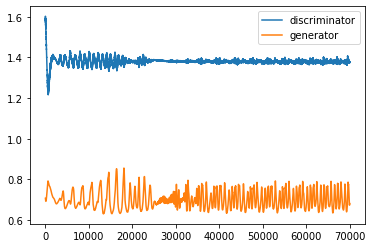

In [7]:
# Creat the folder to store images
if not os.path.exists('eg11.1/'):
    os.makedirs('eg11.1/')

num_iter = 70000
batch_size = 1000
num_sample = 10000  # used in plot

noise_dim = 1
g1_dim = 5
g2_dim = 5
data_dim = 1
d1_dim = 10
d2_dim = 10

# Set random seed for reproducibility
seed = 100
np.random.seed(seed)
tf.random.set_seed(seed)

# Make generator and discriminator
generator = make_generator(noise_dim, g1_dim, g2_dim, data_dim)
discriminator = make_discriminator(data_dim, d1_dim, d2_dim)

# Adam optimizer
lr = 1e-4
generator_optimizer = tf.keras.optimizers.Adam(lr)
discriminator_optimizer = tf.keras.optimizers.Adam(lr)

# Plot results before training
plot(0)

# Training iteration
genloss_l = []
discloss_l = []
for iter in range(1, num_iter + 1):
    real_sample = sample_x(batch_size, data_dim)
    noise = sample_z(real_sample.shape[0], noise_dim)
    loss_gen, loss_disc = train_step(real_sample, noise)
    genloss_l.append(loss_gen)
    discloss_l.append(loss_disc)

    if iter % 1000 == 0:
        print(f'iteration: {iter}, loss_disc: {loss_disc:.4}, loss_gen: {loss_gen:.4}')
        plot(iter)

# Plot the training curves
print('----Training Curves----')
plt.plot(range(len(genloss_l)), discloss_l, label='discriminator')
plt.plot(range(len(genloss_l)), genloss_l, label='generator')
plt.legend()
plt.savefig('eg11.1/training_curve.png')
plt.show()


